# Build U-Net++ Model for Segmentation

1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?
> KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?
> U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?
> U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.15.0
1.26.2
8.3.2
0.18.3
1.1.0


# Augmentation with albumentations

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

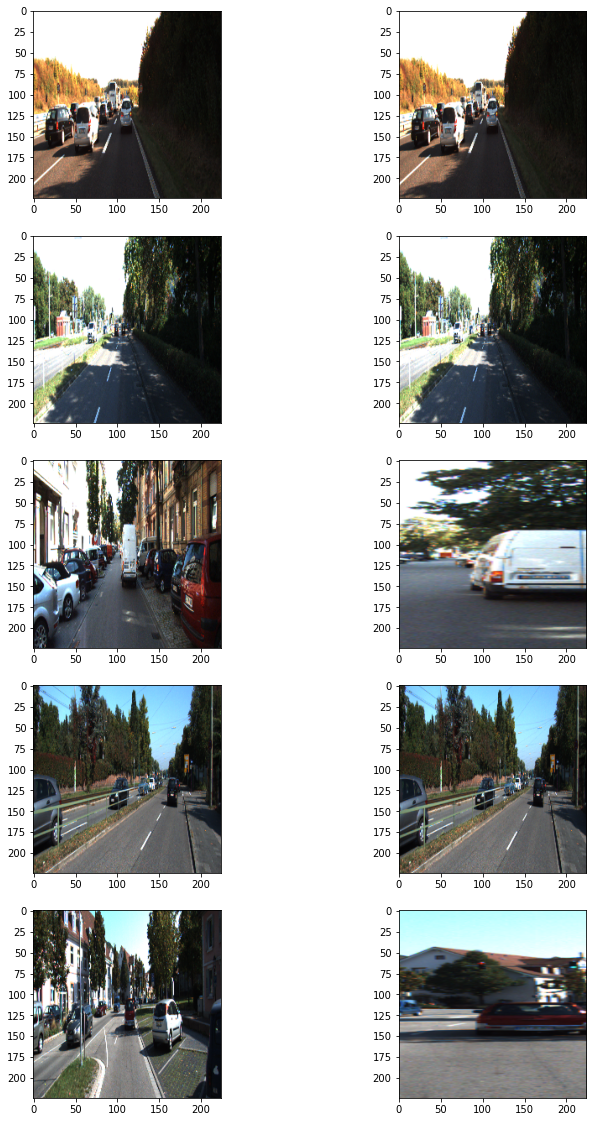

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

# Data generator

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

# Instances

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# Define Conv block and build UNet++ model

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from keras.regularizers import l2

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = l2(1e-4), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [12]:
def build_model(input_shape=(224, 224, 3), deep_supervision=False):
    inputs = Input(input_shape)
    num_filters = [32, 64, 128, 256, 512]
    
    # Level 1
    conv1_1 = conv_block(inputs, num_filters=num_filters[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_1)  # 첫 번째 맥스 풀링

    # Level 2
    conv2_1 = conv_block(pool1, num_filters=num_filters[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_1)  # 두 번째 맥스 풀링
    
    # Upsampling
    up1_2 = Conv2DTranspose(num_filters[1], (2, 2), strides=(2, 2), padding='same')(conv2_1)
    
    # Skip
    conv1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = conv_block(conv1_2, num_filters=num_filters[0])
    
    # Level 3
    conv3_1 = conv_block(pool2, num_filters=num_filters[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_1)
    
    # Upsampling
    up2_2 = Conv2DTranspose(num_filters[1], (2, 2), strides=(2, 2), padding='same')(conv3_1)
    
    # Skip Connection
    conv2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = conv_block(conv2_2, num_filters=num_filters[1])
    
    # Upsampling
    up1_3 = Conv2DTranspose(num_filters[0], (2, 2), strides=(2, 2), padding='same')(conv2_2)
    
    # Skip Connection
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis=3)
    conv1_3 = conv_block(conv1_3, num_filters=num_filters[0])
    
    # Level 4
    conv4_1 = conv_block(pool3, num_filters=num_filters[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_1)
    
    # Upsampling
    up3_2 = Conv2DTranspose(num_filters[2], (2, 2), strides=(2, 2), padding='same')(conv4_1)
    
    # Skip Connection
    conv3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = conv_block(conv3_2, num_filters=num_filters[2])
    
    # Upsampling
    up2_3 = Conv2DTranspose(num_filters[1], (2, 2), strides=(2, 2), padding='same')(conv3_2)
    
    # Skip
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis=3)
    conv2_3 = conv_block(conv2_3, num_filters=num_filters[1])
    
    # Upsampling
    up1_4 = Conv2DTranspose(num_filters[0], (2, 2), strides=(2, 2), padding='same')(conv2_3)
    
    # Skip
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis=3)
    conv1_4 = conv_block(conv1_4, num_filters=num_filters[0])
    
    # Level 5
    conv5_1 = conv_block(pool4, num_filters=num_filters[4])
    
    ########
    
    # Upsampling
    up4_2 = Conv2DTranspose(num_filters[3], (2, 2), strides=(2, 2), padding='same')(conv5_1)
    
    # Skip
    conv4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = conv_block(conv4_2, num_filters=num_filters[3])
    
    # Upsampling
    up3_3 = Conv2DTranspose(num_filters[2], (2, 2), strides=(2, 2), padding='same')(conv4_2)
    
    # Skip
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis=3)
    conv3_3 = conv_block(conv3_3, num_filters=num_filters[2])
    
    # Upsampling
    up2_4 = Conv2DTranspose(num_filters[1], (2, 2), strides=(2, 2), padding='same')(conv3_3)
    
    # Skip
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis=3)
    conv2_4 = conv_block(conv2_4, num_filters=num_filters[1])
    
    # Upsampling
    up1_5 = Conv2DTranspose(num_filters[0], (2, 2), strides=(2, 2), padding='same')(conv2_4)
    
    # Skip
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis=3)
    conv1_5 = conv_block(conv1_5, num_filters=num_filters[0])

    # Final Convolution
    output_1 = Conv2D(1, (1, 1), padding="same", kernel_initializer = 'he_normal', activation="sigmoid", 
                      kernel_regularizer=l2(1e-4))(conv1_2)
    output_2 = Conv2D(1, (1, 1), activation='sigmoid',kernel_initializer = 'he_normal', padding='same', 
                      kernel_regularizer=l2(1e-4))(conv1_3)
    output_3 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', 
                      kernel_regularizer=l2(1e-4))(conv1_4)
    output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', 
                      padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=inputs, outputs=[output_1,
                                               output_2,
                                               output_3,
                                               output_4])
    else:
        model = Model(inputs=inputs, outputs=[output_4])

    return model
    
    # TODO: input_shape에 따라 U-Net++를 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.

In [13]:
model = build_model(input_shape=(224,224,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 224, 224, 32)         896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 224, 224, 32)         128       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 224, 224, 32)         0         ['batch_normalization_15[0

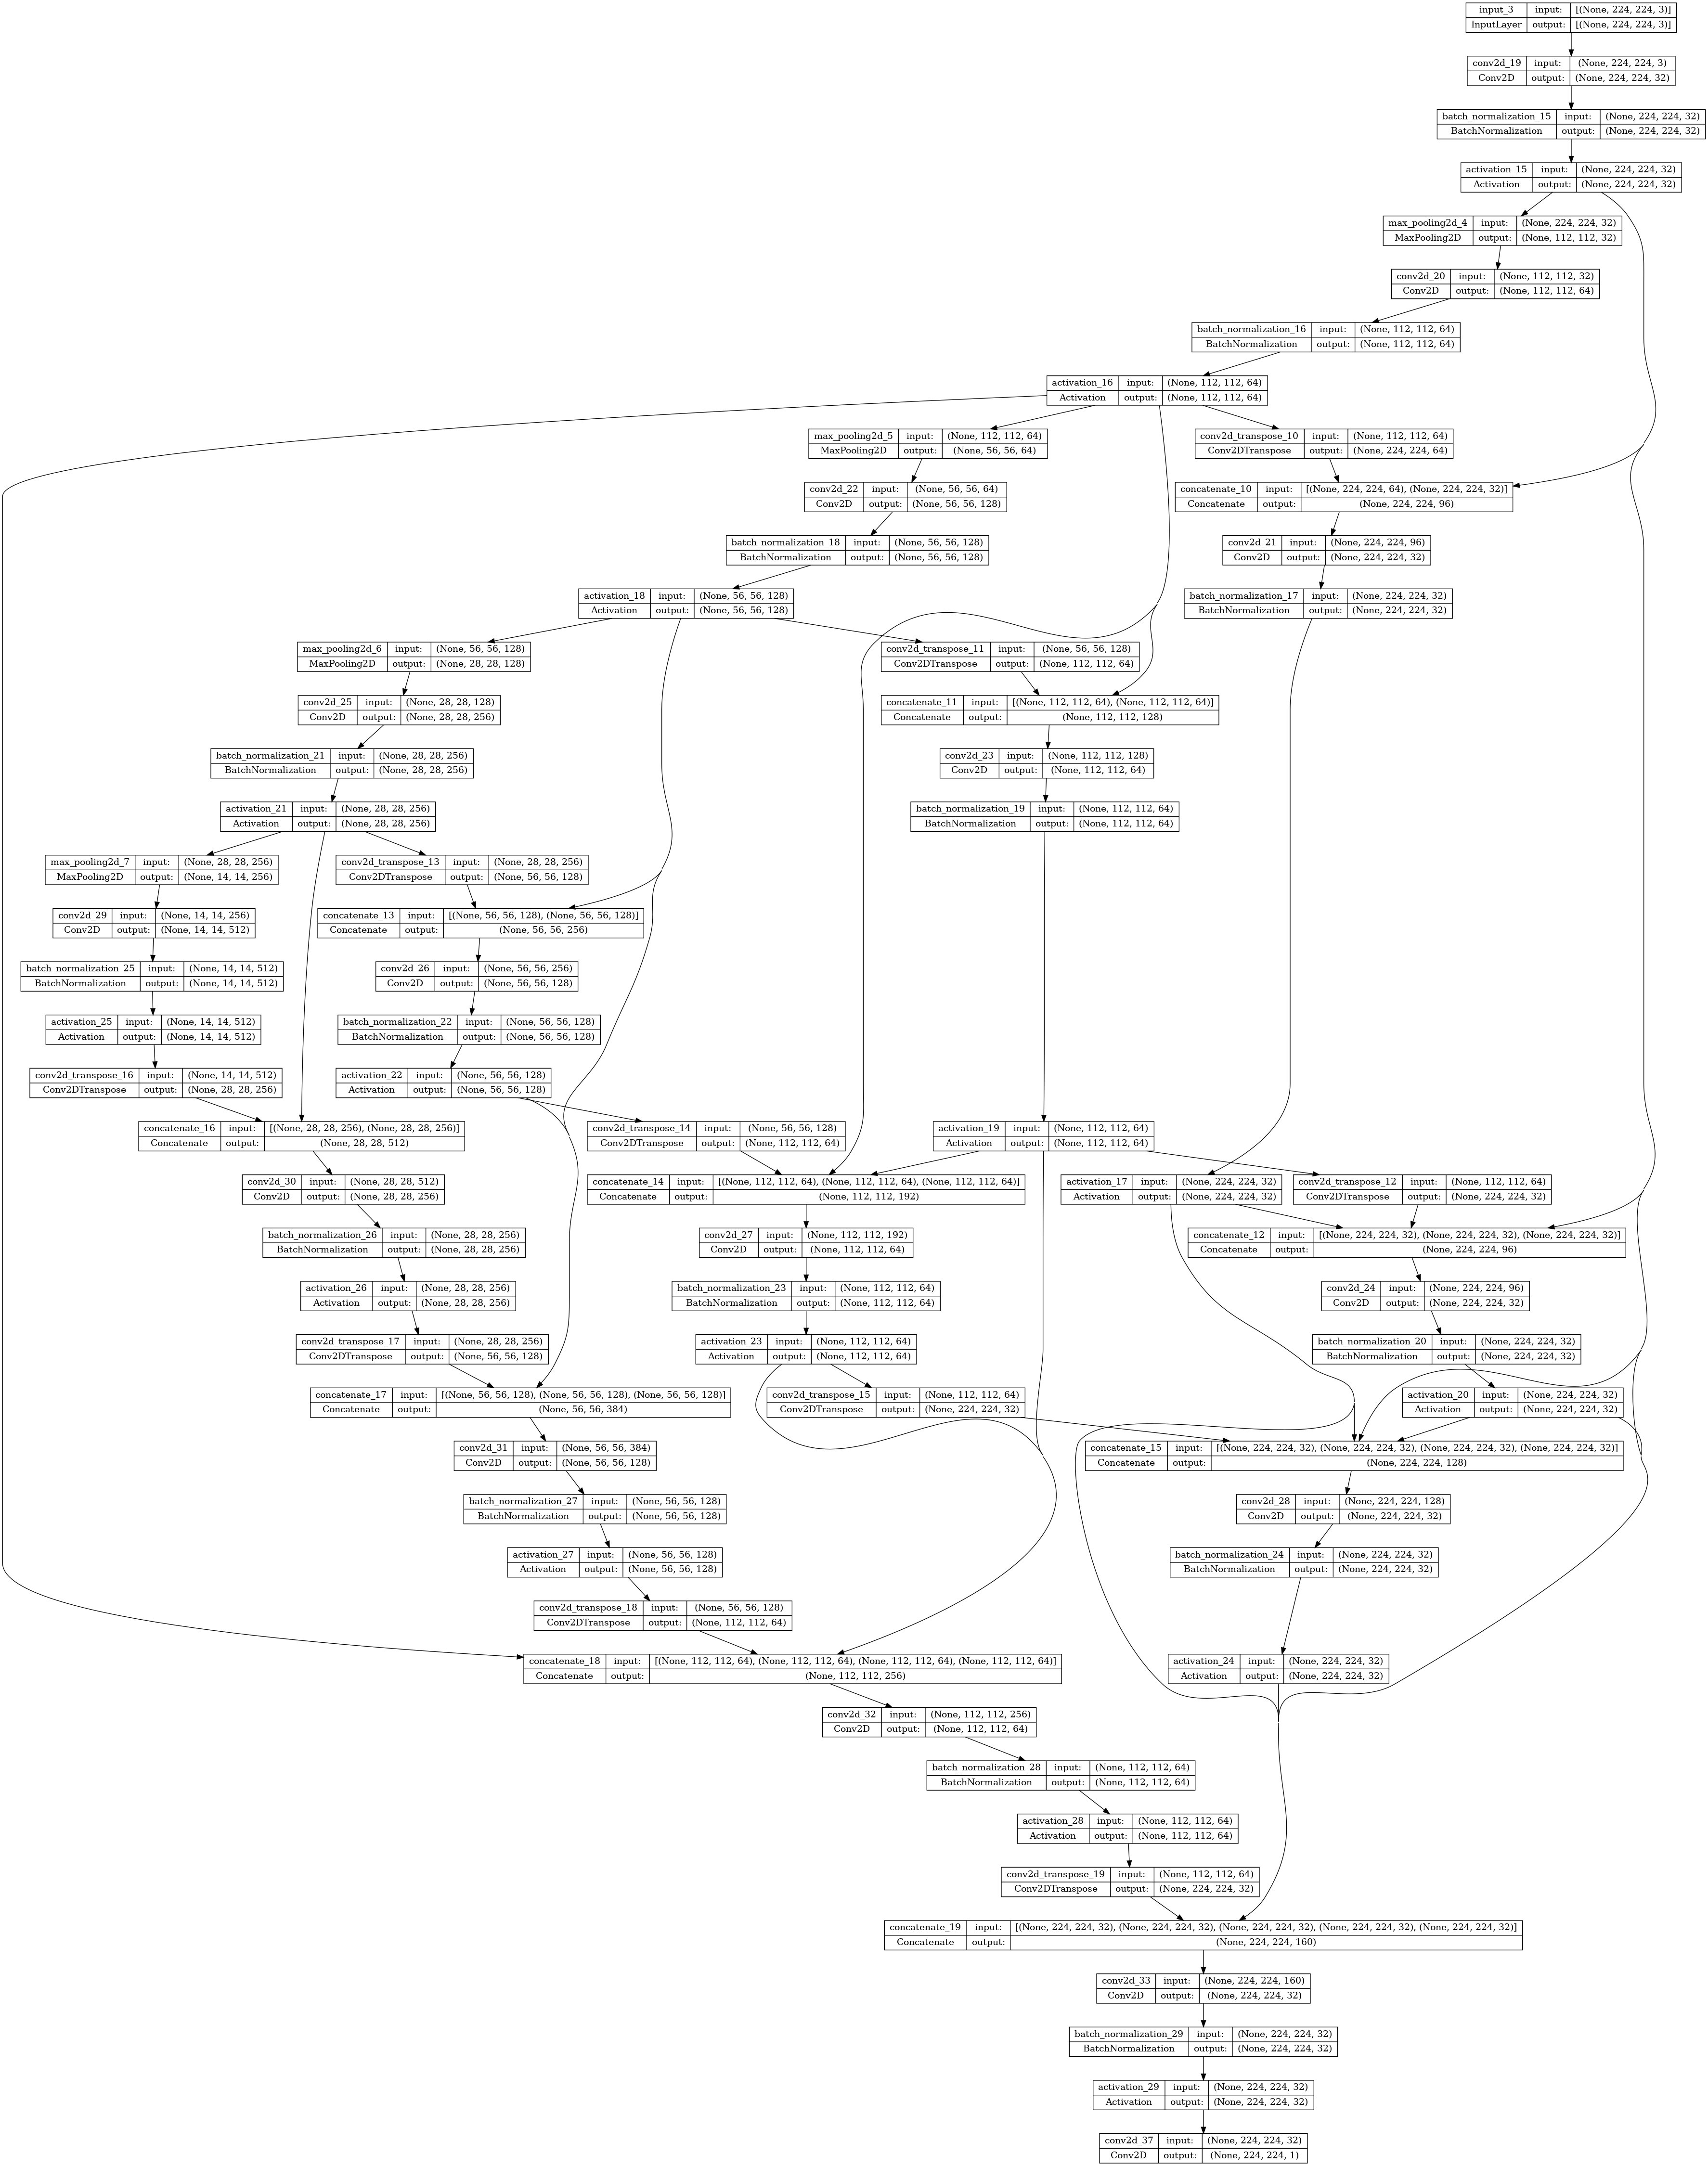

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=15,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/15
22/22 [==============================] - 314s 14s/step - loss: 1.0836 - val_loss: 1.0340
Epoch 2/15
22/22 [==============================] - 307s 14s/step - loss: 1.0068 - val_loss: 1.0100
Epoch 3/15
22/22 [==============================] - 306s 14s/step - loss: 0.9756 - val_loss: 0.9889
Epoch 4/15
22/22 [==============================] - 305s 14s/step - loss: 0.9507 - val_loss: 0.9699
Epoch 5/15
22/22 [==============================] - 311s 14s/step - loss: 0.9248 - val_loss: 0.9570
Epoch 6/15
22/22 [==============================] - 306s 14s/step - loss: 0.9099 - val_loss: 0.9437
Epoch 7/15
22/22 [==============================] - 307s 14s/step - loss: 0.8952 - val_loss: 0.9356
Epoch 8/15
22/22 [==============================] - 309s 14s/step - loss: 0.8892 - val_loss: 0.9281
Epoch 9/15
22/22 [==============================] - 309s 14s/step - loss: 0.8820 - val_loss: 0.9168
Epoch 10/15
22/22 [==============================] - 310s 14s/step - loss: 0.8761 - val_loss: 0.9115

/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
# model_path = dir_path + '/seg_model_unet.h5' 
model = tf.keras.models.load_model(model_path)

# Evaluation Model

In [18]:
# 모델 컴파일 - 평가를 위해 모델을 컴파일합니다.
# loss 함수와 메트릭을 모델이 예측하는 작업에 적합한 것으로 선택해야 합니다.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 평가 - 테스트 데이터 제너레이터를 사용하여 평가를 수행합니다.
results = model.evaluate(test_generator)

# 결과 출력
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

4/4 [==============================] - 14s 3s/step - loss: 0.8636 - accuracy: 0.9823
Test Loss: 0.8636115789413452
Test Accuracy: 0.9823390245437622


# IoU score

In [19]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = intersection / union if union != 0 else 0.0
    print('IoU : %f' % iou_score)
    return iou_score

In [22]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.8)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

# Visualization

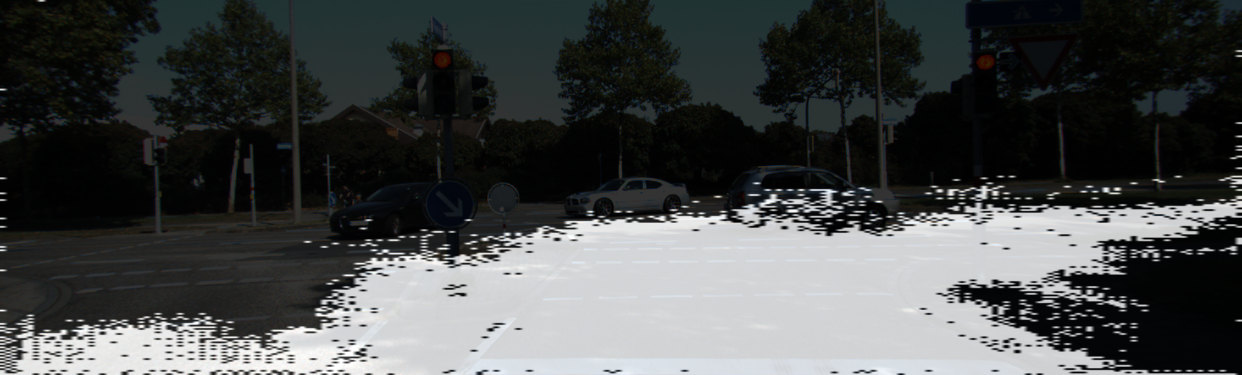

IoU : 0.573916


0.5739164520103035

In [24]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## 회고: Deep supervision을 True로 한다면 어떤 결과가 나올지 궁금했지만, 소요시간이 오래 걸릴 것 같아서 도전해보지 못했다. Unet++를 사용하기 위해서 github에서 코드를 가져오는 과정이 나중에 실제 문제를 풀 때 도움이 될 것 같았다. 그리고 학습 1epoch당 300s가 걸리는 문제가 있었는데, 어떤 부분이 문제였는지 확인이 필요해보였다. 